In [194]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
import xarray as xr
import matplotlib.pyplot as plt
import intake
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import combine_datasets, merge_variables, match_metrics
import utils.geo as geo
import numpy as np
import gsw

from xgcm import Grid

In [231]:
variables = ['vo', 'thetao', 'so']
z_kwargs = {'consolidated': True, 'use_cftime': True}
kwargs = dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'}, preprocess=combined_preprocessing, aggregate=False)
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
             source_id=['GISS-E2-1-H']# 'GISS-E2-1-H', 'E3SM-1-1-ECA', 'E3SM-1-1'
            )

col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(**query)
dd = cat.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [232]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

ddnow = merge_variables(dd)
ddnow = combine_datasets(
    ddnow,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(ddnow.keys())
ds = ddnow['GISS-E2-1-H.gr.historical.Omon'].isel(time=slice(0,36))

In [233]:
# Thermodynamics
ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])

In [234]:
# Get dx in meters
dlon = ds['lon_bounds'].diff('bnds')
dlon = dlon.where(dlon>0,1)
dlat = ds['lat_bounds'].diff('bnds')
dx,dy = geo._degrees_to_meters(dlon, dlat, ds['lon'], ds['lat'])
ds['dx']=dx.squeeze()
ds['dy']=dy.squeeze()
# Get dz in meters
ds['dz'] = ds['lev_bounds'].diff('bnds').squeeze()
# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

In [235]:
# Correct masking issue with vo
ds['vo'] = ds['vo'].where(ds['vo']<1e2,0)

In [236]:
ds['vdz'] = ds['vo']*ds['dz']

xgrid = Grid(ds, coords={'Z': {'center':'lev','outer':'lev_outer'}}, periodic=False)
ds['sigma0_i'] = xgrid.interp(ds['sigma0'],'Z',boundary='extend')
target_sig0 = np.linspace(26, 28, 50)

# Rechunk along lev_outer dimension
ds = ds.chunk(dict(lev_outer=-1))

vdzs = xgrid.transform(ds['vdz'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear')

In [237]:
# Integrate in x
vdzdxs = (vdzs*ds['dx']).sum('x')
# And cumulative sum in z
### NEED TO REVERSE THIS ###
psi = np.cumsum(vdzdxs[:,:,::-1])[:,:,::-1]
# psi = vdzdxs.cumsum('sigma0')

/srv/conda/envs/notebook/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


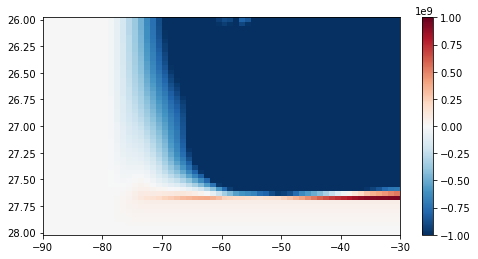

In [238]:
fig,ax = plt.subplots(figsize=(8,4))
select = {'y':slice(-90,-30)}
x = psi['y'].sel(**select)
y = psi['sigma0']
z = psi.sel(**select).mean('time').transpose()
im = ax.pcolormesh(x,y,z,cmap='RdBu_r',vmin=-1e9,vmax=1e9)
ax.invert_yaxis()
plt.colorbar(im,ax=ax)